In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import jaccard_score, classification_report, confusion_matrix

from CR_LO import Loader
from CR_FE_B import FExtractor

import pandas as pd
import geopandas as gpd
import numpy as np


new_features = [gpd.read_file(f'/home/stagiaire/D/D/mesh/{i}_clean.shp') for i in range(1, 5)]

to_keep = ['p_vegeta', 'len_roads', 'profile_co', 'nb_connect', 'min_connec', 'slope', 'id']
for i in range(4):
    new_features[i] = new_features[i].drop(columns=set(new_features[i].columns) - set(to_keep))
    
sample_size = 120
batch_size = 16

it = 5
metrics = []
feature_importance = [[] for _ in range(774)]
feature_importance = np.array(feature_importance)

for i in range(it):

    processor = Loader(opt_root_dir=f"/home/stagiaire/D/D/patchs/{412}n", sar_root_dir=f"/home/stagiaire/D/D/patchs/{412}Rn", num_folds=1)
    processor.load_data(sample_size=sample_size, batch_size=batch_size)
    loader = processor.loaders[0]
    feature_extractor = FExtractor(dataloader=loader, use_8_bit=True)
    train_features, train_labels, train_ids = feature_extractor.extract_features()
    
    train_dict = {}
    for i in range(len(train_ids)):
        train_dict[train_ids[i]] = [train_features[i].tolist(), train_labels[i]]

    new_tr_feat = pd.concat(new_features, ignore_index=True)
    new_tr_feat = new_tr_feat[new_tr_feat['id'].isin(train_ids)]

    for index, row in new_tr_feat.iterrows():
        row_values = row[new_tr_feat.columns != 'id'].tolist()
        train_dict[row['id']][0] = train_dict[row['id']][0] + row_values

    train_features = []
    train_labels = []
    train_ids = []
    
    for key, value in train_dict.items():
        train_ids.append(key)
        train_features.append(value[0])
        train_labels.append(value[1])
    
    processor = Loader(opt_root_dir=f"/home/stagiaire/D/D/patchs/{3}n", sar_root_dir=f"/home/stagiaire/D/D/patchs/{3}Rn", num_folds=1)
    processor.load_data(sample_size=sample_size, batch_size=batch_size)
    loader = processor.loaders[0]
    feature_extractor = FExtractor(dataloader=loader, use_8_bit=True)
    test_features, test_labels, test_ids = feature_extractor.extract_features()
    
    test_dict = {}
    for i in range(len(test_ids)):
        test_dict[test_ids[i]] = [test_features[i].tolist(), test_labels[i]]

    new_te_features = new_features[2][new_features[2]['id'].isin(test_ids)]

    for index, row in new_te_features.iterrows():
        row_values = row[new_te_features.columns != 'id'].tolist()
        test_dict[row['id']][0] = test_dict[row['id']][0] + row_values

    test_features = []
    test_labels = []
    test_ids = []
    
    for key, value in test_dict.items():
        test_ids.append(key)
        test_features.append(value[0])
        test_labels.append(value[1])
    
    rf_model = RandomForestClassifier(n_estimators=400)
    rf_model.fit(np.array(train_features), np.array(train_labels))
    
    predictions = rf_model.predict(np.array(test_features))
    predictions_inv, test_labels_inv = [1 if p == 0 else 0 for p in predictions], [1 if l == 0 else 0 for l in test_labels]
    
    feature_importance = np.hstack((feature_importance, (np.array(rf_model.feature_importances_).reshape(-1, 1))))
    
    IoU = jaccard_score(test_labels_inv, predictions_inv)
    cm = confusion_matrix(test_labels_inv, predictions_inv)
    df_cm = pd.DataFrame(cm, index=['Actual Class 0', 'Actual Class 1'], columns=['Predicted Class 0', 'Predicted Class 1'])
    cr = classification_report(test_labels_inv, predictions_inv)

    print(f"\nJaccard index: {IoU*100: 0.1f}%\n")
    print(f"\n{df_cm}\n")
    print(f"\n{cr}\n")
    metrics.append([cm, cr, IoU])

/home/stagiaire/miniconda3/envs/croma/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/stagiaire/miniconda3/envs/croma/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.48it/s]


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.53it/s]



Jaccard index:  84.5%


                Predicted Class 0  Predicted Class 1
Actual Class 0                115                  7
Actual Class 1                 13                109


              precision    recall  f1-score   support

           0       0.90      0.94      0.92       122
           1       0.94      0.89      0.92       122

    accuracy                           0.92       244
   macro avg       0.92      0.92      0.92       244
weighted avg       0.92      0.92      0.92       244


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.53it/s]


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.55it/s]



Jaccard index:  84.7%


                Predicted Class 0  Predicted Class 1
Actual Class 0                113                  9
Actual Class 1                 11                111


              precision    recall  f1-score   support

           0       0.91      0.93      0.92       122
           1       0.93      0.91      0.92       122

    accuracy                           0.92       244
   macro avg       0.92      0.92      0.92       244
weighted avg       0.92      0.92      0.92       244


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.42it/s]


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.57it/s]



Jaccard index:  71.7%


                Predicted Class 0  Predicted Class 1
Actual Class 0                 99                 23
Actual Class 1                 18                104


              precision    recall  f1-score   support

           0       0.85      0.81      0.83       122
           1       0.82      0.85      0.84       122

    accuracy                           0.83       244
   macro avg       0.83      0.83      0.83       244
weighted avg       0.83      0.83      0.83       244


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.42it/s]


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.60it/s]



Jaccard index:  83.8%


                Predicted Class 0  Predicted Class 1
Actual Class 0                114                  8
Actual Class 1                 13                109


              precision    recall  f1-score   support

           0       0.90      0.93      0.92       122
           1       0.93      0.89      0.91       122

    accuracy                           0.91       244
   macro avg       0.91      0.91      0.91       244
weighted avg       0.91      0.91      0.91       244


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:07<00:00,  5.38it/s]


Initializing SAR encoder
Initializing optical encoder
Initializing joint SAR-optical encoder


Extracting Features: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  5.45it/s]



Jaccard index:  83.8%


                Predicted Class 0  Predicted Class 1
Actual Class 0                114                  8
Actual Class 1                 13                109


              precision    recall  f1-score   support

           0       0.90      0.93      0.92       122
           1       0.93      0.89      0.91       122

    accuracy                           0.91       244
   macro avg       0.91      0.91      0.91       244
weighted avg       0.91      0.91      0.91       244




In [2]:
from R import RGenerator

report = RGenerator(metrics).report()

Precision (mean, stdev): 91%, 5%
Recall (mean, stdev): 89%, 2%
F1-score (mean, stdev): 90%, 3%
IoU (mean, stdev): 82%, 5%

[[111.  11.]
 [ 14. 108.]]

[[6. 6.]
 [2. 2.]]



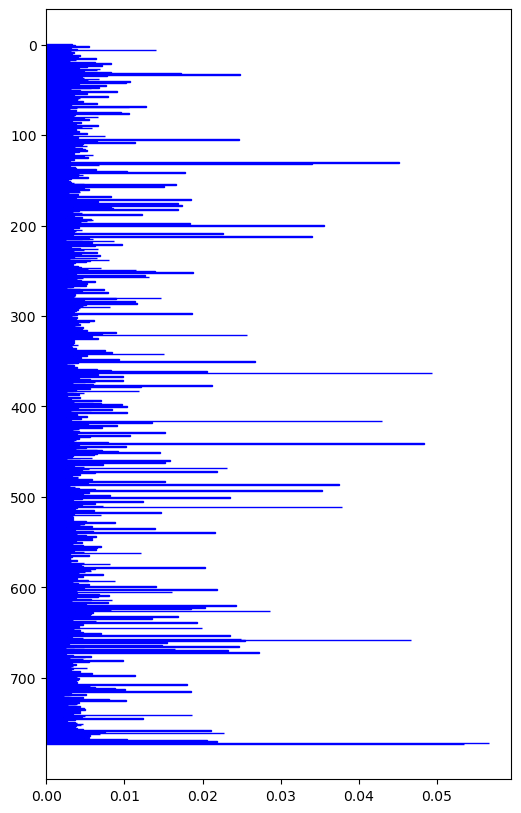

In [3]:
import matplotlib.pyplot as plt
import numpy as np

feature_importance = np.array([np.sum(f) for f in feature_importance])

plt.figure(figsize=(6, 10))
plt.barh(range(774), feature_importance, align='center', color='black', edgecolor='blue')
plt.yticks(range(0, 774, 100))
plt.xlabel('')
plt.title('')
plt.gca().invert_yaxis()
plt.show()

In [4]:
print(sum(feature_importance[:768]/768))
print(sum(feature_importance[768:]/6))

print(sum(feature_importance[:768]))
print(sum(feature_importance[768:]))

0.0062837896910780695
0.02900825287533903
4.825950482747965
0.17404951725203419
